In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For correlation matrix visualization

C:\Users\ganes\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\ganes\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
C:\Users\ganes\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
C:\Users\ganes\AppData\Local\Programs\Python\Python311\Lib\sit

In [3]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA']  # Example tickers
df = pd.read_csv("stock_data.csv", header=1)

df = df.drop(index=0).reset_index(drop=True)

# Convert all columns to numeric where possible (non-convertible values become NaN)
df = df.apply(pd.to_numeric, errors='coerce')

# Fill missing values
df = df.ffill()

# Drop any remaining non-numeric (or all-NaN) columns, if any
df = df.dropna(axis=1, how='all')


# Handle missing values 
data = df.ffill()

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(df)
scaled_data = scaler.fit_transform(scaled_array, columns=df.columns)

print(scaled_df.head())

TypeError: MinMaxScaler.fit() got an unexpected keyword argument 'columns'

In [ ]:
# Create edge index from correlation matrix
correlation_matrix = data.corr()
edge_index = []
threshold = 0.7  # Only include edges with correlation above this threshold
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            edge_index.append([i, j])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Create node features (scaled stock prices)
node_features = torch.tensor(scaled_data, dtype=torch.float)

# Create PyTorch Geometric Data object
graph_data = Data(x=node_features, edge_index=edge_index)

In [4]:
class GraphLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GraphLSTM, self).__init__()
        self.gcn = GCNConv(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        # Graph Convolution
        x = self.gcn(x, edge_index)
        x = F.relu(x)
        x = x.unsqueeze(0)  # Add batch dimension
        x, _ = self.lstm(x)
        x = x.squeeze(0)  # Remove batch dimension

        # Fully Connected Layer
        x = self.fc(x)
        return x

In [5]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
X_train, X_test, y_train, y_test = train_test_split(
    scaled_data, scaled_data, test_size=0.2, random_state=42
)  

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

NameError: name 'scaled_data' is not defined

In [14]:
model = GraphLSTM(input_dim=len(tickers), hidden_dim=64, output_dim=len(tickers), num_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train, graph_data.edge_index)  
    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test, graph_data.edge_index) 
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch [10/200], Train Loss: 0.1721, Test Loss: 0.1519
Epoch [20/200], Train Loss: 0.0764, Test Loss: 0.0698
Epoch [30/200], Train Loss: 0.0664, Test Loss: 0.0676
Epoch [40/200], Train Loss: 0.0606, Test Loss: 0.0621
Epoch [50/200], Train Loss: 0.0594, Test Loss: 0.0609
Epoch [60/200], Train Loss: 0.0589, Test Loss: 0.0603
Epoch [70/200], Train Loss: 0.0584, Test Loss: 0.0596
Epoch [80/200], Train Loss: 0.0577, Test Loss: 0.0589
Epoch [90/200], Train Loss: 0.0568, Test Loss: 0.0578
Epoch [100/200], Train Loss: 0.0554, Test Loss: 0.0563
Epoch [110/200], Train Loss: 0.0530, Test Loss: 0.0535
Epoch [120/200], Train Loss: 0.0480, Test Loss: 0.0480
Epoch [130/200], Train Loss: 0.0376, Test Loss: 0.0371
Epoch [140/200], Train Loss: 0.0227, Test Loss: 0.0235
Epoch [150/200], Train Loss: 0.0194, Test Loss: 0.0219
Epoch [160/200], Train Loss: 0.0165, Test Loss: 0.0186
Epoch [170/200], Train Loss: 0.0126, Test Loss: 0.0142
Epoch [180/200], Train Loss: 0.0079, Test Loss: 0.0095
Epoch [190/200], Tr

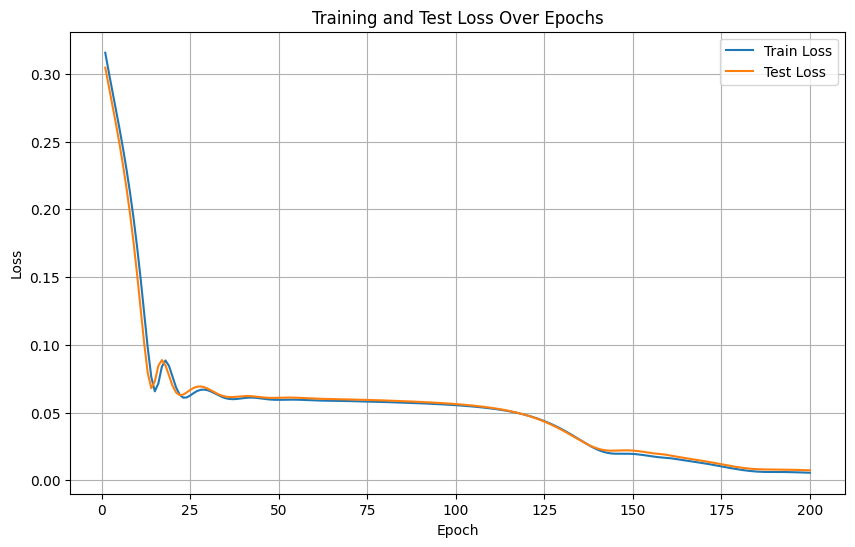

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

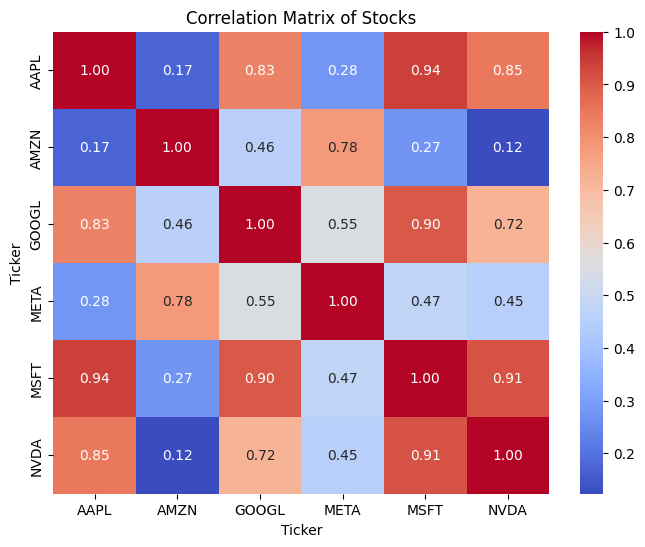

In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Stocks')
plt.show()


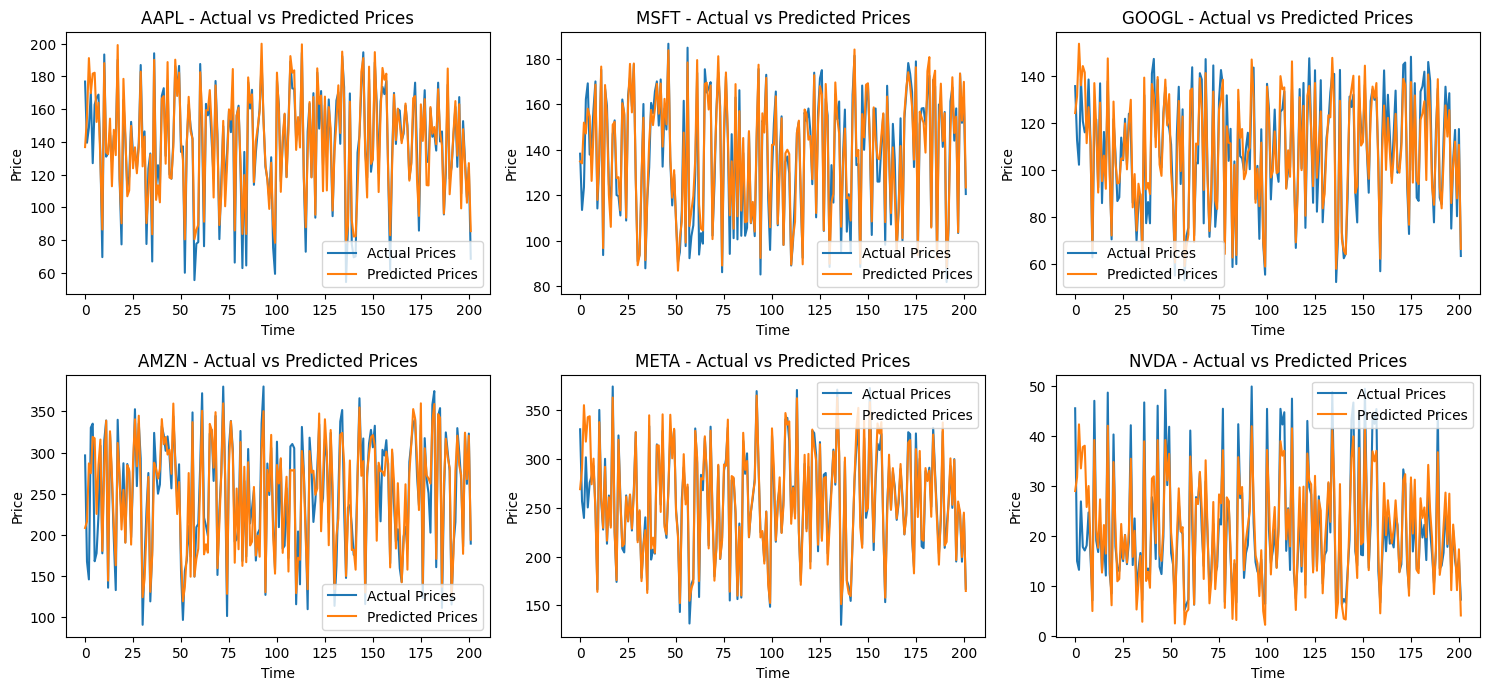

Prediction Accuracy: 91.70%


In [17]:
model.eval()
with torch.no_grad():
    graph_data.x = X_test
    predicted_prices = model(graph_data.x, graph_data.edge_index).detach().numpy()

predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test.numpy())

plt.figure(figsize=(15, 10))
for i, ticker in enumerate(tickers):
    plt.subplot(3, 3, i + 1)
    plt.plot(actual_prices[:, i], label='Actual Prices')
    plt.plot(predicted_prices[:, i], label='Predicted Prices')
    plt.title(f'{ticker} - Actual vs Predicted Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
plt.tight_layout()
plt.show()

# Mean of absoulte percentage error
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100
accuracy = 100 - mape

print(f"Prediction Accuracy: {accuracy:.2f}%")


In [32]:
def predict_tomorrow_prices(model, scaler, tickers):
    from datetime import datetime, timedelta
    import yfinance as yf
    import torch
    import pandas as pd

    # Step 1: Download latest data
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
    raw_data = yf.download(tickers, start=start_date, end=end_date)

    # Check if 'Adj Close' is in multi-index
    if isinstance(raw_data.columns, pd.MultiIndex):
        if 'Adj Close' in raw_data.columns.levels[0]:
            new_data = raw_data['Adj Close']
        else:
            new_data = raw_data['Close']
    else:
        new_data = raw_data['Adj Close'] if 'Adj Close' in raw_data.columns else raw_data['Close']

    new_data = new_data.ffill()

    # Step 2: Scale data
    scaled = scaler.transform(new_data)
    features = torch.tensor(scaled, dtype=torch.float)

    # Step 3: Graph construction from correlation
    corr_matrix = new_data.corr()
    edge_index = []
    threshold = 0.7
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                edge_index.append([i, j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Step 4: Predict
    model.eval()
    with torch.no_grad():
        outputs = model(features, edge_index)
        last_prediction_scaled = outputs[-1].unsqueeze(0).numpy()
        tomorrow_prediction = scaler.inverse_transform(last_prediction_scaled)

    # Step 5: Return predictions
    predicted_prices = {
        tickers[i]: round(tomorrow_prediction[0][i], 2) for i in range(len(tickers))
    }

    print(f" Predicted stock prices for the specific date ({(datetime.now() + timedelta(days=1)).strftime('%Y-%m-%d')}):")
    for ticker, price in predicted_prices.items():
        print(f"{ticker}: ${price}")

    return predicted_prices


In [33]:
predict_tomorrow_prices(model, scaler, tickers)

[*********************100%***********************]  6 of 6 completed


 Predicted stock prices for the specific date (2025-04-25):
AAPL: $206.72999572753906
MSFT: $177.72999572753906
GOOGL: $164.36000061035156
AMZN: $421.4200134277344
META: $418.0400085449219
NVDA: $54.13999938964844


{'AAPL': 206.73,
 'MSFT': 177.73,
 'GOOGL': 164.36,
 'AMZN': 421.42,
 'META': 418.04,
 'NVDA': 54.14}

In [30]:
def predict_stock_price_on_date(model, scaler, tickers, target_ticker, target_date, data):
    
    if target_ticker not in tickers:
        raise ValueError("Ticker not in the list of trained stocks")

    if target_date not in data.index.strftime('%Y-%m-%d'):
        raise ValueError("Date not available in the dataset")

    # Get index of the target date
    date_index = list(data.index.strftime('%Y-%m-%d')).index(target_date)
    
    # Get scaled input up to the date
    input_data = scaler.transform(data)
    input_tensor = torch.tensor(input_data, dtype=torch.float)

    # Create graph structure (using same logic as before)
    correlation_matrix = data.corr()
    edge_index = []
    threshold = 0.7
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                edge_index.append([i, j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Predict using model
    model.eval()
    with torch.no_grad():
        x = input_tensor
        output = model(x, edge_index)
        predicted_scaled = output[date_index].numpy().reshape(1, -1)
        predicted_unscaled = scaler.inverse_transform(predicted_scaled)

    stock_idx = tickers.index(target_ticker)
    predicted_price = predicted_unscaled[0][stock_idx]
    actual_price = data.iloc[date_index][target_ticker]

    print(f"Predicted price of {target_ticker} on {target_date}: ${predicted_price:.2f}")
    print(f"Actual price of {target_ticker} on {target_date}: ${actual_price:.2f}")

    return predicted_price, actual_price


In [31]:
# Call the function after training
target_stock = 'AAPL'
target_date = '2022-06-15'

predicted, actual = predict_stock_price_on_date(model, scaler, tickers, target_stock, target_date, data)


Predicted price of AAPL on 2022-06-15: $139.90
Actual price of AAPL on 2022-06-15: $133.47
